# Predicting Terry Stop Arrests
Author: Carlos Garza

# Overview
This notebook details the building, tuning and deployment of a categorical model that predicts whether an arrest was made during traffic stops by the Seattle Police. Tools utilized include but are not limited to K-Nearest Neighbors models, decision trees, random forests, and XGBoost.

Because the data includes race and gender of both the officers and suspects, this will be a purely objective model based on public data and will not include further social commentary. Social issues regarding race and gender are outside of the scope of this project.

# Business Problem
In the late 1960's, the supreme court ruled in Terry vs. Ohio that "stop and frisk" police tactics are not a violation of constitutional rights. Because of this, police can detain a person on the grounds of "reasonable suspicion," even in the absence of clearer evidence.

This ruling lead to the coining of the term Terry Stop, which is when an officer of the law briefly detains a driver based on the reasonable suspician that the driver is involved in criminal activity.

Based on data from Terry Stops from the Seattle Police Department, a classifying model can be built to predict if a Terry Stop will result in an arrest, and from that model the most influencial factors in an arrest can be determined.

# Data

The data utilized in this project comes from [data.seattle.gov](https://data.seattle.gov/Public-Safety/Terry-Stops/28ny-9ts8) and consists of 46.3k Terry Stops, as reported by the conducting officer. A copy of the csv file can be found in the data folder of this repository or at [data.gov](https://catalog.data.gov/dataset/terry-stops).

### Exploratory Data Analysis
Exploring the data to develop a preprocessing and modeling strategy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('data/Terry_Stops.csv')
df.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,-,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,...,11:32:00,-,-,-,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2
1,-,-1,20150000001463,28806,Field Contact,None,5670,1965,M,White,...,07:59:00,-,-,-,NaN,N,N,-,-,-
2,-,-1,20150000001516,29599,Field Contact,None,4844,1961,M,White,...,19:12:00,-,-,-,NaN,N,-,-,-,-
3,-,-1,20150000001670,32260,Field Contact,None,7539,1963,M,White,...,04:55:00,-,-,-,NaN,N,N,-,-,-
4,-,-1,20150000001739,33155,Field Contact,None,6973,1977,M,White,...,00:41:00,-,-,-,NaN,N,N,-,-,-


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46248 entries, 0 to 46247
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         46248 non-null  object
 1   Subject ID                46248 non-null  int64 
 2   GO / SC Num               46248 non-null  int64 
 3   Terry Stop ID             46248 non-null  int64 
 4   Stop Resolution           46248 non-null  object
 5   Weapon Type               46248 non-null  object
 6   Officer ID                46248 non-null  object
 7   Officer YOB               46248 non-null  int64 
 8   Officer Gender            46248 non-null  object
 9   Officer Race              46248 non-null  object
 10  Subject Perceived Race    46248 non-null  object
 11  Subject Perceived Gender  46248 non-null  object
 12  Reported Date             46248 non-null  object
 13  Reported Time             46248 non-null  object
 14  Initial Call Type     

In [4]:
for column in df.columns:
    print(column, '\n')
    print(df[column].value_counts())
    print('_________')

Subject Age Group 

26 - 35         15381
36 - 45          9762
18 - 25          9322
46 - 55          5980
56 and Above     2345
1 - 17           1961
-                1497
Name: Subject Age Group, dtype: int64
_________
Subject ID 

-1              34742
 7726859935        19
 7753260438        18
 7727117712        13
 12795904212       11
                ...  
 7728382188         1
 7728607474         1
 7725672697         1
 7725797630         1
 16219707395        1
Name: Subject ID, Length: 8632, dtype: int64
_________
GO / SC Num 

20160000378750    16
20150000190790    16
20180000134604    14
20190000441736    13
20170000132836    13
                  ..
20190000410715     1
20160000174160     1
20170000156685     1
20200000272466     1
20180000071981     1
Name: GO / SC Num, Length: 36213, dtype: int64
_________
Terry Stop ID 

19268585233    3
19324329995    3
13080077761    3
15045077325    3
12119304761    2
              ..
76432          1
250511         1
383630        

<AxesSubplot:>

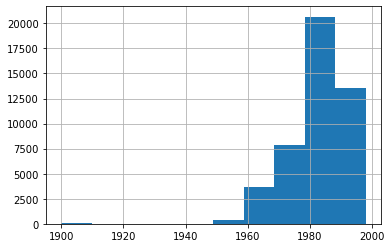

In [5]:
df['Officer YOB'].hist()

### Data Preprocessing

To begin I dropped the columns that identify specific suspects or officers, as well as locational variables to make a more generalized dataset. Additionally, call types were dropped as the categorical data is expansive.

In [6]:
to_drop = ['Subject ID', 'GO / SC Num', 'Terry Stop ID', 'Officer ID',
           'Initial Call Type', 'Final Call Type', 'Call Type', 'Officer Squad',
           'Precinct', 'Sector', 'Beat']

In [7]:
df.drop(to_drop, axis=1, inplace=True)
df.head()

,Subject Age Group,Stop Resolution,Weapon Type,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Reported Date,Reported Time,Arrest Flag,Frisk Flag
0,-,Arrest,None,1984,M,Black or African American,Asian,Male,2015-10-16T00:00:00,11:32:00,N,N
1,-,Field Contact,None,1965,M,White,-,-,2015-03-19T00:00:00,07:59:00,N,N
2,-,Field Contact,None,1961,M,White,White,Male,2015-03-21T00:00:00,19:12:00,N,-
3,-,Field Contact,None,1963,M,White,-,-,2015-04-01T00:00:00,04:55:00,N,N
4,-,Field Contact,None,1977,M,White,Black or African American,Male,2015-04-03T00:00:00,00:41:00,N,N


In the following lines I use the 'Stop Resolution' and 'Arrest Flag' columns to create a binary 'Arrested' column.

In [8]:
def define_arrested(resolution, flag):
    if resolution == 'Arrest' or flag == 'Y':
        return 1
    else:
        return 0

In [9]:
df['Arrested'] = df.apply(lambda x: define_arrested(x['Stop Resolution'], x['Arrest Flag']), axis=1)
df.drop(['Stop Resolution', 'Arrest Flag'], axis=1, inplace=True)        

For 'Frisk Flag and 'Weapon Type' columns, I will assume that missing data signifies no frisk/weapon. 

In [10]:
df['Frisk Flag'] = df['Frisk Flag'].map(lambda x: 1 if x == 'Y' else 0)

In [11]:
df['Weapon Type'] = df['Weapon Type'].map(lambda x: 'None' if x == '-' else x)

For date and time, the data will be converted to numerical 'month' and 'hour' columns respecively. 

In [12]:
df['Reported Month'] = df['Reported Date'].map(lambda x: int(x[5:7]))
df.drop('Reported Date', axis=1, inplace=True)

In [13]:
df['Reported Hour'] = df['Reported Time'].map(lambda x: int(x[:2]))
df.drop('Reported Time', axis = 1, inplace=True)

Outliers and generic place-holder answers are dropped.

In [14]:
df.drop(df[df['Officer YOB']<1940].index, inplace=True)
df.drop(df[df['Subject Perceived Gender']=='-'].index, inplace=True)
df.drop(df[df['Subject Perceived Race']=='-'].index, inplace=True)
df.drop(df[df['Subject Age Group']=='-'].index, inplace=True)

To be sure no collinearity problems will arise, the correlation between dependent variables needs to be checked.

Alpha = 0.05

In [15]:
df.drop('Arrested', axis=1).corr()

,Officer YOB,Frisk Flag,Reported Month,Reported Hour
Officer YOB,1.000000,0.027183,-0.019369,-0.045488
Frisk Flag,0.027183,1.000000,0.008921,0.018031
Reported Month,-0.019369,0.008921,1.000000,-0.000423
Reported Hour,-0.045488,0.018031,-0.000423,1.000000


Lastly, data is separated into training and testing sets and the categorical variables will be one hot encoded.

In [16]:
from sklearn.model_selection import train_test_split

y = df.Arrested
X = df.drop('Arrested', axis=1)
X = pd.get_dummies(X, drop_first=True)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=40)

# Baseline Models

Models that will be auditioned are K Nearest Neighbors, decision trees, random forest, and XGBoost

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### K Nearest Neighbor

In [19]:
scaler = StandardScaler()

# Transform the training and test sets
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [20]:
knn = KNeighborsClassifier()
knn.fit(scaled_X_train, y_train)
y_train_pred = knn.predict(scaled_X_train)
y_test_pred = knn.predict(scaled_X_test)
print('accuracy score: ', accuracy_score(y_test, y_test_pred))

accuracy score:  0.7068949560388709


### Decision Tree

In [21]:
dsc = DecisionTreeClassifier(max_depth=3)
dsc.fit(X_train, y_train)
y_pred = dsc.predict(X_test)
print('accuracy score: ', accuracy_score(y_test, y_pred))

accuracy score:  0.7434521055067098


### Random Forest

In [22]:
rfc = RandomForestClassifier(max_depth=3)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print('accuracy score: ', accuracy_score(y_test, y_pred))

accuracy score:  0.7445627024525683


### XGBoost

In [23]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print('accuracy score: ', accuracy_score(y_test, y_pred))

accuracy score:  0.7409532623785284


Because our decision tree and random forest performed best, they will be focused on moving forward.

# Model Tuning/Reitteration

GridSearchCV will be used to tune the hyperparameters of the algorithms to maximize their performance.

### Decision Tree

In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
dtc = DecisionTreeClassifier()

dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

gs_tree = GridSearchCV(dtc, dt_param_grid, cv=3)
gs_tree.fit(X_train, y_train)
gs_tree.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [26]:
gs_tree.score(X_test, y_test)

0.7434521055067098

In [27]:
rfc = RandomForestClassifier()

rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 4, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

gs_forest = GridSearchCV(rfc, rf_param_grid, cv=3)
gs_forest.fit(X_train, y_train)
gs_forest.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 6,
 'min_samples_split': 10,
 'n_estimators': 100}

In [28]:
gs_forest.score(X_test, y_test)

0.7439148542341508

Accuracy is slightly improved after optimization, but only by a negligible amount. Models must be further evaluated to find the model with the best performance.

# Model Evaluation

The two contesting models will be further evaluated to narrow down to the best performing model for deployment.

In [29]:
from sklearn.metrics import plot_confusion_matrix, recall_score, precision_score, f1_score

def metric_scores(actual, predicted):
    print('Accuracy Score: ', accuracy_score(actual, predicted))
    print('Recall Score: ', recall_score(actual, predicted))
    print('Precision Score: ', precision_score(actual, predicted))
    print('F1 Score: ', f1_score(actual, predicted))

### Decision Tree

In [30]:
dtree = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=1, min_samples_split=2)
dtree.fit(X_train, y_train)
tree_pred = dtree.predict(X_test)

In [31]:
metric_scores(y_test, tree_pred)

Accuracy Score:  0.7434521055067098
Recall Score:  0.042391304347826085
Precision Score:  0.47560975609756095
F1 Score:  0.0778443113772455


Text(0.5, 1.0, 'Decision Tree Confusion Matrix')

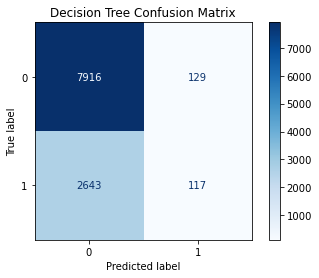

In [32]:
plot_confusion_matrix(dtree, X_test, y_test, cmap=plt.cm.Blues)
plt.title('Decision Tree Confusion Matrix')

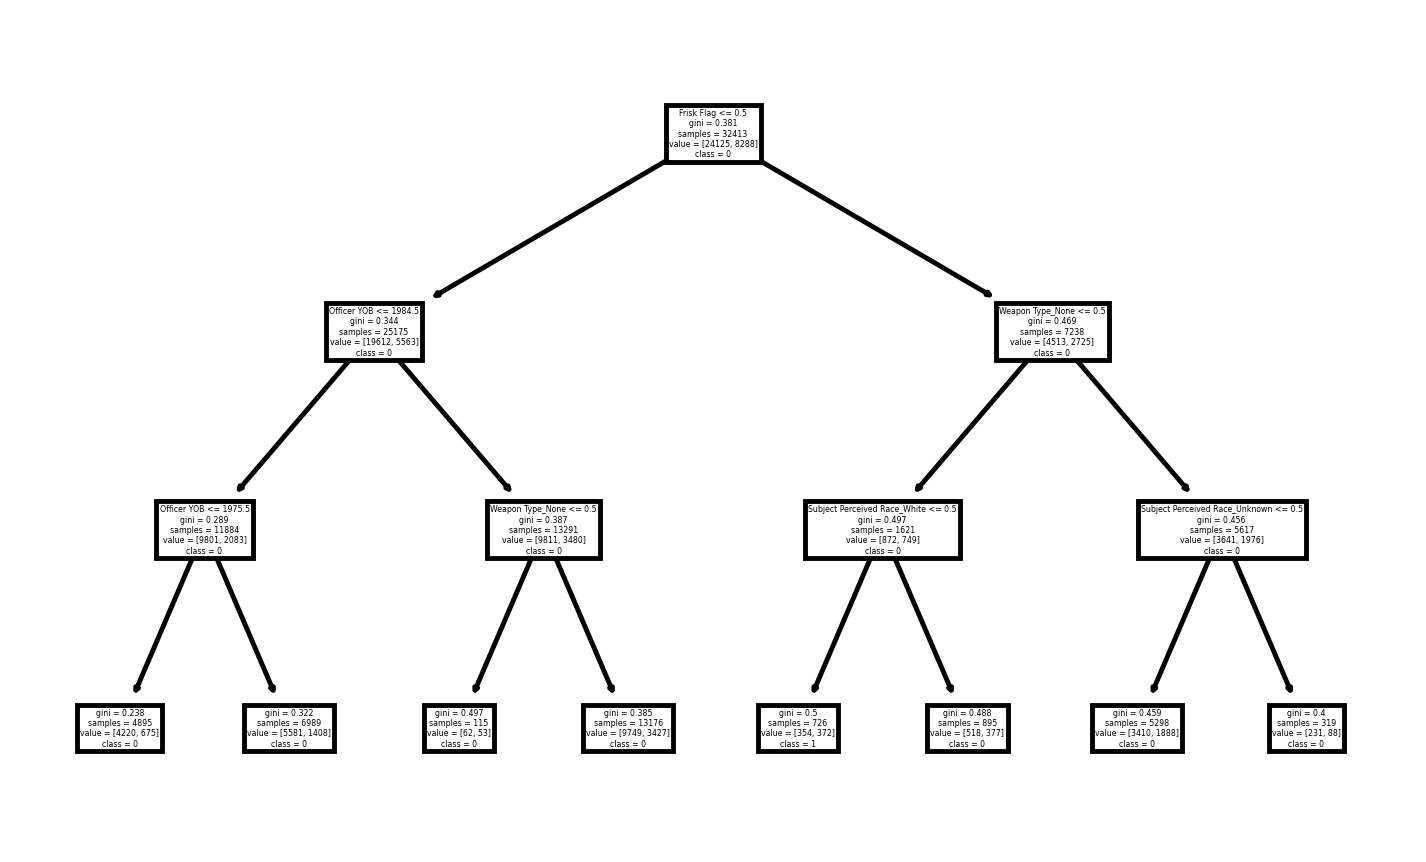

In [33]:
from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (5,3), dpi=350)
tree.plot_tree(dtree,
               feature_names = X_train.columns, 
               class_names=np.unique(y_train).astype('str'),
               filled = False)
plt.show()

The tree is not overfitted, but does have a large amount of false negative predictions.

### Random Forest

In [34]:
rforest = RandomForestClassifier(criterion='gini', max_depth=None, min_samples_leaf=6,
                                 min_samples_split=10, n_estimators=100)
rforest.fit(X_train, y_train)
forest_pred = rforest.predict(X_test)

In [35]:
metric_scores(y_test, forest_pred)

Accuracy Score:  0.7441925034706155
Recall Score:  0.021014492753623187
Precision Score:  0.48333333333333334
F1 Score:  0.04027777777777777


Text(0.5, 1.0, 'Random Forest Confusion Matrix')

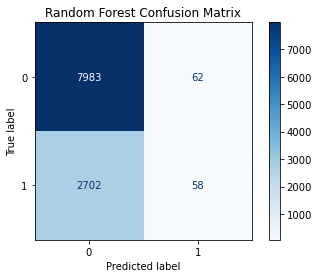

In [36]:
plot_confusion_matrix(rforest, X_test, y_test, cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix')

The random forest model performed similarly to the decision tree. To save processing time and power, the final model is the decision tree.

# Feature Importance

Text(0, 0.5, 'Feature')

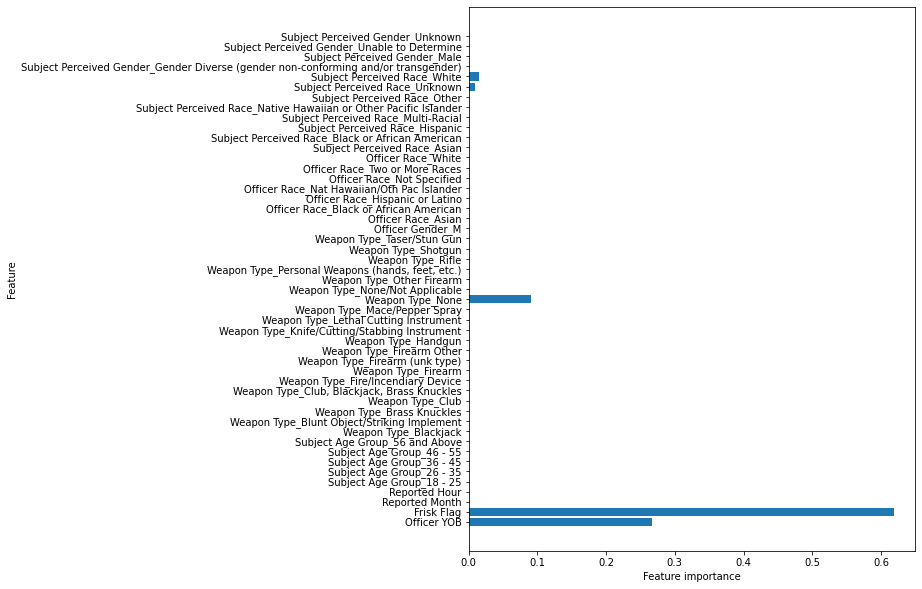

In [37]:
plt.figure(figsize=(8,10))
plt.barh(range(len(X_train.columns)), dtree.feature_importances_, align='center') 
plt.yticks(np.arange(len(X_train.columns)), X_train.columns.values) 
plt.xlabel('Feature importance')
plt.ylabel('Feature')

# Conclusions

The most important feature to a random stop influencing if a subject is arrested is whether or not the subject was frisked. Following that is the age of the officer and whether or not the subject had any weapons. the type of weapon did not matter. 

The decision tree classifier trained with this data had an accuracy rating of about 75%

# Future Work

In the future it would be beneficial to explore ways to decrease the rate of false positives in our model.

Also, incorporating data from a wider geographic area could make for a more comprehensive model.